# Convolutional Variational Autoencoder Implementation on Burst Windows

In [2]:
from ipyfilechooser import FileChooser
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from scipy.stats import linregress
import os

### Import data

In [3]:
fc = FileChooser('./')  # or use an absolute path if needed
fc.title = "<b>Select preprocessing parameter file</b>"
fc.filter_pattern = ['*.npz']  # Only show .par files
display(fc)

FileChooser(path='C:\Users\aguin\Desktop\BASUS', filename='', title='<b>Select preprocessing parameter file</b…

In [5]:
data = dict(np.load(fc.selected, allow_pickle=True))

In [6]:
windows = np.array(data['handlesA'].item()['burst_windows'])
labels = data['handlesA'].item()['species']
assert windows.shape[0] == labels.shape[0]
windows.shape

(861, 21)

In [7]:
X_raw = torch.tensor(windows, dtype=torch.float32)  # shape: (N, 21)
min_val = X_raw.min()
max_val = X_raw.max()

X = (X_raw - min_val) / (max_val - min_val)
X = X.unsqueeze(1)  # (N, 1, 21)
#X = torch.log1p(X)
if torch.cuda.is_available():
    X = X.cuda()
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
X

tensor([[[9.2140e-05, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00]],

        [[2.4271e-03, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          9.2166e-05, 1.8434e-03]],

        [[0.0000e+00, 0.0000e+00, 6.7622e-04,  ..., 0.0000e+00,
          0.0000e+00, 9.2512e-05]],

        ...,

        [[1.9133e-03, 7.4587e-04, 1.9134e-03,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00]],

        [[1.9134e-03, 0.0000e+00, 1.3297e-03,  ..., 0.0000e+00,
          7.4598e-04, 0.0000e+00]],

        [[7.4645e-04, 0.0000e+00, 7.4646e-04,  ..., 1.6273e-04,
          0.0000e+00, 1.3302e-03]]], device='cuda:0')

## Convolutional VAE Architecture

In [ ]:
class ConvVAE(nn.Module):
    def __init__(self, input_length = 21, latent_dim = 3):
        super(ConvVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),    #(B, 16, 21)
            nn.BatchNorm1d(16),
            nn.ReLU(),
            
            nn.Conv1d(16, 32, kernel_size=3, padding=1),   #(B, 32, 21)
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),                               #(B, 32, 10)
            
            nn.Conv1d(32, 64, kernel_size=3, padding=1),   #(B, 64, 10)
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),                               #(B, 64, 5)
            
            nn.Conv1d(64, 128, kernel_size=3, padding=1),  #(B, 128, 5)
            nn.BatchNorm1d(128),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128*5, latent_dim)
        self.fc_logvar = nn.Linear(128*5, latent_dim)

        self.decoder_input = nn.Linear(latent_dim, 128*5)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, 5)),                    #(B, 128, 5)
            nn.ConvTranspose1d(128, 64, kernel_size=3, padding=1),  #(B, 64, 5)
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),                  #(B, 64, 10)
            nn.ConvTranspose1d(64, 32, kernel_size=3, padding=1),   #(B, 32, 10)
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),                  #(B, 32, 20)
            nn.Conv1d(32, 16, kernel_size=3, padding=1),  #(B, 16, 20)
            nn.ReLU(),
            nn.Conv1d(16, 1, kernel_size=2, padding=0),   #(B, 1, 21)
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, 5)),                    # -> (B, 128, 5)
            nn.ConvTranspose1d(128, 64, kernel_size=3, padding=1),  # -> (B, 64, 5)
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),                  # -> (B, 64, 10)
            nn.ConvTranspose1d(64, 32, kernel_size=3, padding=1),   # -> (B, 32, 10)
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),                  # -> (B, 32, 20)
            nn.Conv1d(32, 16, kernel_size=3, padding=1),  # -> (B, 16, 20)
            nn.ReLU(),
            nn.Conv1d(16, 1, kernel_size=3, padding=1),   # -> (B, 1, 20)
            nn.Conv1d(1, 1, kernel_size=2, padding=1)     # -> (B, 1, 21)
        )

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        return mu + std * torch.randn_like(std)
    
    def forward(self, x):
        enc = self.encoder(x)
        enc_flat = enc.view(x.size(0), -1)
        mu = self.fc_mu(enc_flat)
        logvar = self.fc_logvar(enc_flat)
        z = self.reparametrize(mu, logvar)
        z_dec = self.decoder_input(z)
        recon = self.decoder(z_dec)
        return recon, mu, logvar
    
def vae_loss(recon, x, mu, logvar, beta=0.001):
    recon_loss = F.mse_loss(recon, x, reduction='mean')
    kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta*kl_div

In [36]:
loader = DataLoader(TensorDataset(X), batch_size = 8)
model = ConvVAE(input_length=21, latent_dim=3).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 2e-4)
num_epochs = 30

### Training Loop

Epoch 1 - Loss: 0.0134
Epoch 2 - Loss: 0.0051
Epoch 3 - Loss: 0.0046
Epoch 4 - Loss: 0.0042
Epoch 5 - Loss: 0.0039
Epoch 6 - Loss: 0.0035
Epoch 7 - Loss: 0.0033
Epoch 8 - Loss: 0.0031
Epoch 9 - Loss: 0.0029
Epoch 10 - Loss: 0.0027
Epoch 11 - Loss: 0.0025
Epoch 12 - Loss: 0.0024
Epoch 13 - Loss: 0.0021
Epoch 14 - Loss: 0.0021
Epoch 15 - Loss: 0.0021
Epoch 16 - Loss: 0.0018
Epoch 17 - Loss: 0.0018
Epoch 18 - Loss: 0.0016
Epoch 19 - Loss: 0.0017
Epoch 20 - Loss: 0.0016
Epoch 21 - Loss: 0.0016
Epoch 22 - Loss: 0.0015
Epoch 23 - Loss: 0.0014
Epoch 24 - Loss: 0.0013
Epoch 25 - Loss: 0.0013
Epoch 26 - Loss: 0.0012
Epoch 27 - Loss: 0.0012
Epoch 28 - Loss: 0.0012
Epoch 29 - Loss: 0.0012
Epoch 30 - Loss: 0.0012


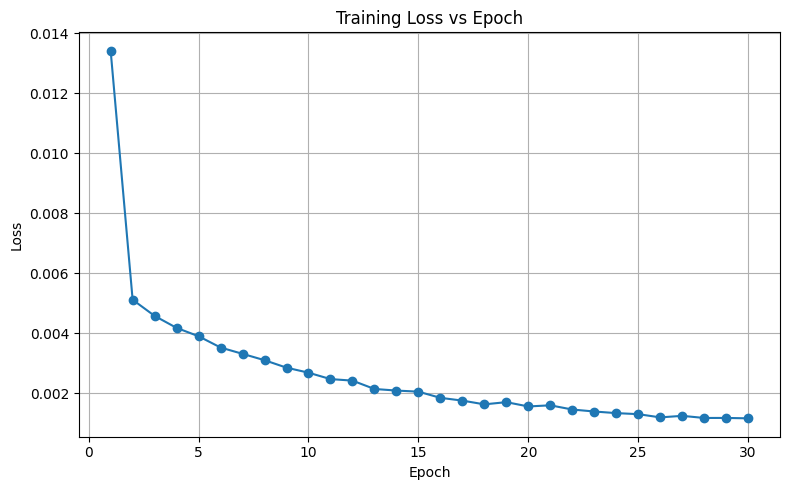

In [37]:
losses = []

for epoch in range(num_epochs):
    total_loss = 0
    for batch in loader:
        x_batch = batch[0].to(DEVICE)
        recon, mu, logvar = model(x_batch)
        loss = vae_loss(recon, x_batch, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    losses.append(total_loss / len(loader))
    print(f"Epoch {epoch+1} - Loss: {total_loss / len(loader):.4f}")
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), losses, marker='o')
plt.title("Training Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

In [38]:
model.eval()
latents = []

with torch.no_grad():
    for batch in loader:
        x_batch = batch[0].to(DEVICE)
        enc = model.encoder(x_batch)
        enc_flat = enc.view(x_batch.size(0), -1)
        mu = model.fc_mu(enc_flat)
        latents.append(mu.cpu().numpy())
        

latents = np.concatenate(latents, axis=0)

assert latents.shape[0] == len(labels)

#pca = PCA(n_components=3)
#z_pca = pca.fit_transform(latents)


fig = go.Figure(data=[go.Scatter3d(
    x=latents[:, 0],
    y=latents[:, 1],
    z=latents[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        color=labels,
        colorscale='viridis',
        opacity=0.8,
        colorbar=dict(title='Species')
    )
)])

fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    title='Latent Space',
    margin=dict(l=0, r=0, b=0, t=30)
)

fig.show()


fig = go.Figure(data=[go.Scatter3d(
    x=latents[:, 0][labels!=0],
    y=latents[:, 1][labels!=0],
    z=latents[:, 2][labels!=0],
    mode='markers',
    marker=dict(
        size=4,
        color=labels[labels!=0],
        colorscale='viridis',
        opacity=0.8,
        colorbar=dict(title='Species')
    )
)])

fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    title='Latent Space',
    margin=dict(l=0, r=0, b=0, t=30)
)

fig.show()

fig = go.Figure(data=[go.Scatter3d(
    x=latents[:, 0][labels!=1],
    y=latents[:, 1][labels!=1],
    z=latents[:, 2][labels!=1],
    mode='markers',
    marker=dict(
        size=4,
        color=labels[labels!=1],
        colorscale='viridis',
        opacity=0.8,
        colorbar=dict(title='Species')
    )
)])

fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    title='Latent Space',
    margin=dict(l=0, r=0, b=0, t=30)
)

fig.show()


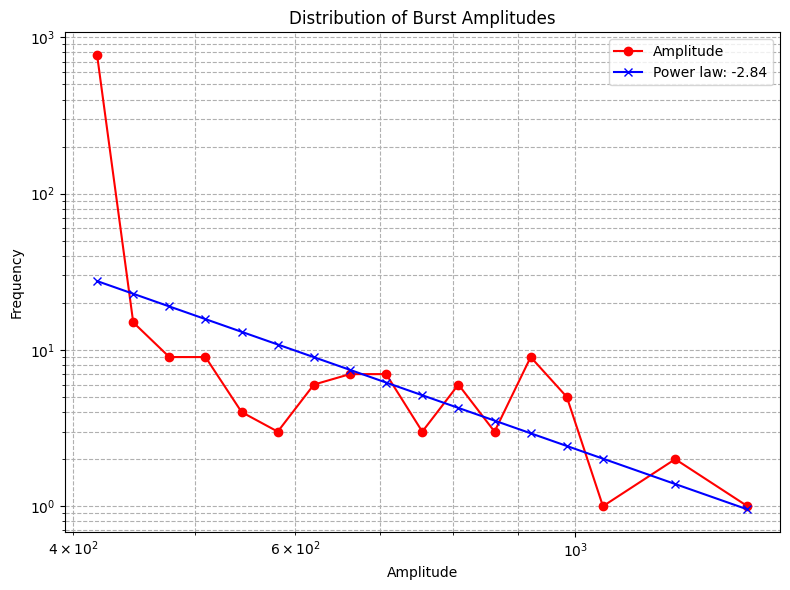

In [24]:
latent_dim = 3
num_samples = windows.shape[0]
z = torch.randn(num_samples, latent_dim).to(DEVICE)
with torch.no_grad():
    decoded = model.decoder(model.decoder_input(z)) #[num_samples, 1, 21]
    decoded = decoded.squeeze(1) #[num_samples, 21]
generated_unscaled = decoded * (max_val - min_val) + min_val
amplitudes = generated_unscaled.max(dim=1).values.cpu().numpy()

#generated_amplitudes = np.max(decoded, axis = 1)
#print(generated_amplitudes)
bins = np.logspace(np.log10(max(min(amplitudes), 1e-6)), np.log10(max(amplitudes)), 20)
hist, bin_edges = np.histogram(amplitudes, bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

nonzero = hist > 0 & (bin_centers > 0)
x = bin_centers[nonzero]
y = hist[nonzero]

log_x = np.log10(x)
log_y = np.log10(y)
slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)
fit_y = 10**(slope * log_x + intercept)

plt.figure(figsize=(8, 6))
plt.loglog(x, y, '-ro', label='Amplitude')
plt.loglog(x, fit_y, '-bx', label=f'Power law: {slope:.2f}')
plt.xlabel('Amplitude')
plt.ylabel('Frequency')
plt.title('Distribution of Burst Amplitudes')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
#plt.savefig(os.path.join(f'{data['newdir'].item()}', "ampdist"))
plt.show()



ValueError: x and y must be the same size

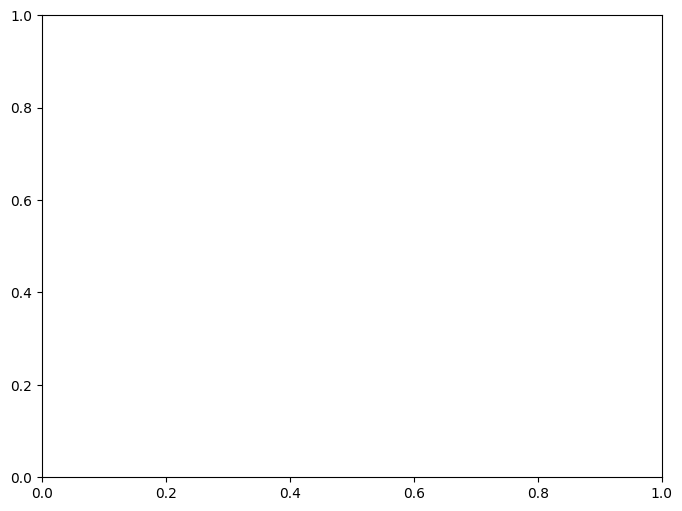

In [39]:
plt.figure(figsize=(8, 6))
plt.scatter(mu[:, 0].cpu(), amplitudes, label="Dim 1")
plt.scatter(mu[:, 1].cpu(), amplitudes, label="Dim 2")
plt.scatter(mu[:, 2].cpu(), amplitudes, label="Dim 3")
plt.xlabel("Latent dim value")
plt.ylabel("Original Amplitude")
plt.title("Latent Dimensions vs Burst Amplitude")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
print(mu.shape, amplitudes.shape)


NameError: name 'amplitudes' is not defined

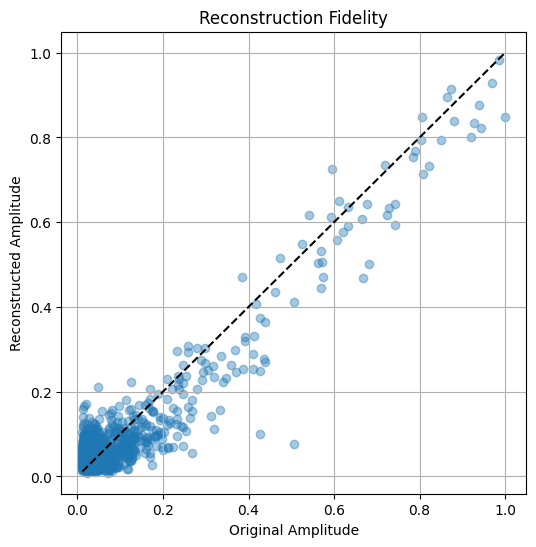

In [55]:
model.eval()
reconstructed = []
true_amp = []
with torch.no_grad():
    for batch in loader:
        x_batch = batch[0].to(DEVICE)
        recon, _, _ = model(x_batch)
        recon_amp = recon.max(dim=2).values.squeeze(1).cpu().numpy()
        orig_amp = x_batch.max(dim=2).values.squeeze(1).cpu().numpy()
        reconstructed.append(recon_amp)
        true_amp.append(orig_amp)

reconstructed = np.concatenate(reconstructed)
true_amp = np.concatenate(true_amp)

plt.figure(figsize=(6,6))
plt.scatter(true_amp, reconstructed, alpha=0.4)
plt.xlabel("Original Amplitude")
plt.ylabel("Reconstructed Amplitude")
plt.title("Reconstruction Fidelity")
plt.grid(True)
plt.plot([min(true_amp), max(true_amp)], [min(true_amp), max(true_amp)], 'k--')
plt.show()


In [37]:
model.eval()
with torch.no_grad():
    z_sample = torch.randn(1000, latent_dim).to(DEVICE)
    recon = model.decoder(model.decoder_input(z_sample)).squeeze(1).cpu().numpy()
    print(np.std(recon, axis=1))  # should not be all zero

[0.02744841 0.01269385 0.02717654 0.03439853 0.02890122 0.03071189
 0.0298781  0.0355228  0.03391146 0.03143333 0.03751101 0.02202155
 0.02658675 0.02102908 0.02580089 0.02079554 0.02726432 0.02797421
 0.02102748 0.02962822 0.02680251 0.02178151 0.01741544 0.02037329
 0.02540726 0.03060885 0.02503498 0.01587315 0.02381457 0.02777372
 0.02292266 0.02175278 0.01915176 0.02681584 0.02356934 0.02665126
 0.02095547 0.02892062 0.01628339 0.02990071 0.02313799 0.03440832
 0.020663   0.01737592 0.01520421 0.01508361 0.02699786 0.0374937
 0.03140729 0.03395113 0.02197127 0.03199605 0.02788278 0.03092173
 0.01946212 0.03049376 0.0293135  0.03651664 0.02101076 0.02912635
 0.02236095 0.03039737 0.02943463 0.02513323 0.01399606 0.0336355
 0.03334437 0.02641714 0.02704482 0.02437356 0.01890318 0.02306781
 0.03538053 0.01865983 0.02427437 0.02133    0.02526344 0.03042842
 0.03212927 0.02874375 0.0334699  0.02116147 0.02843529 0.02253303
 0.02522812 0.01834844 0.01988918 0.02543755 0.035104   0.026026

In [15]:
model.eval()
latents = []
with torch.no_grad():
    for batch in loader:
        x_batch = batch[0].to(DEVICE)
        enc = model.encoder(x_batch)
        enc_flat = enc.view(x_batch.size(0), -1)
        mu = model.fc_mu(enc_flat)
        latents.append(mu.cpu().numpy())

latents = np.vstack(latents)
print("Latent mean:", np.mean(latents, axis=0))
print("Latent std:", np.std(latents, axis=0))


Latent mean: [-0.00792051  0.02198284 -0.01248486]
Latent std: [0.00563469 0.00364615 0.0043575 ]


In [16]:
print(torch.mean(mu, dim=0))
print(torch.std(mu, dim=0))

tensor([-0.0108,  0.0208, -0.0109], device='cuda:0')
tensor([5.6755e-04, 9.7917e-05, 1.4495e-04], device='cuda:0')


<Axes: >

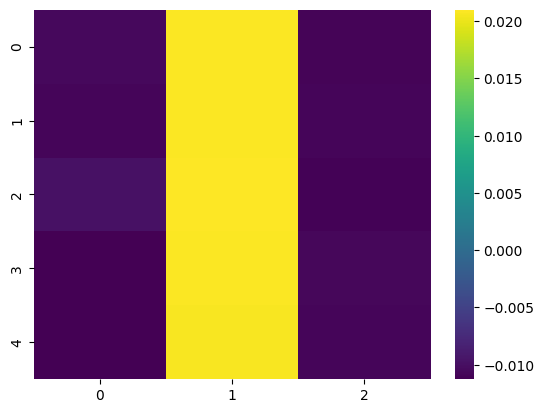

In [17]:
import seaborn as sns
sns.heatmap(mu.cpu().detach().numpy(), cmap="viridis")


In [11]:
grid_x, grid_y, grid_z = np.mgrid[-2:2:10j, -2:2:10j, -2:2:10j]
grid_latents = np.vstack([grid_x.ravel(), grid_y.ravel(), grid_z.ravel()]).T
grid_latents = torch.tensor(grid_latents, dtype=torch.float32).to(DEVICE)